### Reading the datasets and pre-processing

In [1]:
import numpy as np
import pandas as pd

# Function to map insurance types
def map_insurance_type(insurance):
    if insurance in ["Medicaid", "Medicare"]:
        return "public"
    elif insurance == "Private":
        return "private"
    else:
        return "others"

# Function to map age categories
def map_age(age: int) -> str:
    if age < 40:
        return "young"
    elif 40 <= age < 50:
        return "adult"
    elif 50 <= age < 64:
        return "senior"
    else:
        return "elderly"

# Function to map race categories
def map_race(race: str) -> str:
    if race == 'WHITE':
        return 'white'
    elif race == 'BLACK':
        return 'black'
    else:
        return 'others'

# Function to preprocess a DataFrame
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    # Apply the mapping functions
    df['insurance_mapped'] = df['new_insurance_type'].apply(map_insurance_type)
    df['age_mapped'] = df['anchor_age'].apply(map_age)
    df['race_mapped'] = df['race'].apply(map_race)

    # Filter the dataframe to keep only 'public' and 'private' insurance types
    df_filtered = df[df['insurance_mapped'].isin(['public', 'private'])]
    
    # Filter the dataframe to keep only 'young', 'adult', and 'senior' ages
    df_filtered = df_filtered[df_filtered['age_mapped'].isin(['young', 'adult', 'senior'])]

    # Only keep age, gender, race, and insurance type columns
    remove_columns = [column for column in df_filtered.columns if column not in ["age_mapped", "race_mapped", "gender", "insurance_mapped"]]
    df_filtered = df_filtered.drop(columns=remove_columns)
    
    return df_filtered

# Read the datasets
df = pd.read_csv("/local/home/arashasg/Projects/insurance-mimic-analysis/data/insurance_dataset_8_1_1_PMMthree_train_addRaceICD.csv")
df_val = pd.read_csv("/local/home/arashasg/Projects/insurance-mimic-analysis/data/insurance_dataset_8_1_1_PMMthree_val_addRaceICD.csv")
df_test = pd.read_csv("/local/home/arashasg/Projects/insurance-mimic-analysis/data/insurance_dataset_8_1_1_PMMthree_test_addRaceICD.csv")

# Apply the preprocessing function to each dataset
df_filtered = preprocess(df)
df_filtered_val = preprocess(df_val)
df_filtered_test = preprocess(df_test)



# Optionally, print the first few rows of the filtered DataFrames
print(df_filtered.head())
print(df_filtered_val.head())
print(df_filtered_test.head())


  gender insurance_mapped age_mapped race_mapped
0      F           public     senior       white
1      F           public     senior       white
2      F           public     senior       white
3      F           public     senior       white
4      F           public     senior       white
  gender insurance_mapped age_mapped race_mapped
0      F           public     senior       black
1      F           public      young      others
2      M           public     senior       white
3      M           public     senior       white
4      M           public     senior       white
  gender insurance_mapped age_mapped race_mapped
0      M          private      young       white
1      M           public      young       white
2      F           public      young       white
3      F           public      young       white
4      F           public     senior      others


### Correlation Assessment

In [2]:
# Perform One-Hot Encoding for categorical columns (age_mapped, race_mapped, gender, insurance_mapped)
df_encoded = pd.get_dummies(df_filtered, columns=["age_mapped", "race_mapped", "gender", "insurance_mapped"])

# Modify the column names to retain the type (age_young, race_black, gender_F, etc.)
df_encoded.columns = [col.replace('age_mapped_', 'age_') for col in df_encoded.columns]
df_encoded.columns = [col.replace('race_mapped_', 'race_') for col in df_encoded.columns]
df_encoded.columns = [col.replace('insurance_mapped_', 'insurance_') for col in df_encoded.columns]

# List of the columns to consider for categorical features
categorical_features = ['age_adult', 'age_senior', 'age_young', 
                        'race_black', 'race_others', 'race_white', 
                        'gender_F', 'gender_M']

# Columns for insurance types (private and public)
insurance_columns = ['insurance_private', 'insurance_public']

# Create an empty dictionary to store the correlation values
confusion_matrix_data = {}

# Calculate the correlation for each feature with the insurance columns
for feature in categorical_features:
    feature_corr = []
    for insurance in insurance_columns:
        corr_value = df_encoded[feature].corr(df_encoded[insurance])
        feature_corr.append(corr_value)
    confusion_matrix_data[feature] = feature_corr

# Convert the dictionary into a DataFrame (for easy visualization)
confusion_matrix = pd.DataFrame(confusion_matrix_data, index=insurance_columns)
confusion_matrix = confusion_matrix.T

# Optionally, print it to see in the console as well
print(confusion_matrix)


             insurance_private  insurance_public
age_adult            -0.017087          0.017087
age_senior           -0.033431          0.033431
age_young             0.053707         -0.053707
race_black           -0.123010          0.123010
race_others          -0.035606          0.035606
race_white            0.133407         -0.133407
gender_F             -0.018804          0.018804
gender_M              0.018804         -0.018804


In [3]:
import pandas as pd
import scipy.stats as stats

# Perform One-Hot Encoding for categorical columns (age_mapped, race_mapped, gender, insurance_mapped)
df_encoded = pd.get_dummies(df_filtered, columns=["age_mapped", "race_mapped", "gender", "insurance_mapped"])

# Modify the column names to retain the type (age_young, race_black, gender_F, etc.)
df_encoded.columns = [col.replace('age_mapped_', 'age_') for col in df_encoded.columns]
df_encoded.columns = [col.replace('race_mapped_', 'race_') for col in df_encoded.columns]
df_encoded.columns = [col.replace('insurance_mapped_', 'insurance_') for col in df_encoded.columns]

# List of the columns to consider for categorical features
categorical_features = ['age_adult', 'age_senior', 'age_young', 
                        'race_black', 'race_others', 'race_white', 
                        'gender_F', 'gender_M']

# Columns for insurance types (private and public)
insurance_columns = ['insurance_private', 'insurance_public']

# Create an empty dictionary to store the contingency tables, chi-square statistics, and p-values
chi_square_results = {}

# Calculate the Chi-Square test for each feature with the insurance columns
for feature in categorical_features:
    feature_p_value = []
    feature_chi2_stat = []
    
    for insurance in insurance_columns:
        # Create contingency tables for each feature and insurance type
        contingency_table = pd.crosstab(df_encoded[feature], df_encoded[insurance])
        
        # Perform the Chi-Square test of independence
        chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        
        # Store the Chi-Square statistic and p-value for each feature
        feature_chi2_stat.append(chi2_stat)
        feature_p_value.append(p_value)
    
    chi_square_results[feature] = {
        'chi2_stat': feature_chi2_stat,
        'p_value': feature_p_value
    }

# Convert the Chi-Square statistics and p-values into DataFrames for easy visualization
chi2_df = pd.DataFrame({feature: result['chi2_stat'] for feature, result in chi_square_results.items()}, index=insurance_columns)
p_values_df = pd.DataFrame({feature: result['p_value'] for feature, result in chi_square_results.items()}, index=insurance_columns)

# Print the Chi-Square statistic and p-values
print("Chi-Square Test Statistics:")
print(chi2_df)

print("\nChi-Square Test P-Values:")
print(p_values_df)




Chi-Square Test Statistics:
                   age_adult  age_senior  age_young  race_black  race_others  \
insurance_private   9.551353     36.7395  94.924621  498.660979    41.634656   
insurance_public    9.551353     36.7395  94.924621  498.660979    41.634656   

                   race_white  gender_F  gender_M  
insurance_private   586.66937  11.58988  11.58988  
insurance_public    586.66937  11.58988  11.58988  

Chi-Square Test P-Values:
                   age_adult    age_senior     age_young     race_black  \
insurance_private   0.001998  1.350159e-09  1.977746e-22  1.859153e-110   
insurance_public    0.001998  1.350159e-09  1.977746e-22  1.859153e-110   

                    race_others     race_white  gender_F  gender_M  
insurance_private  1.100255e-10  1.328530e-129  0.000663  0.000663  
insurance_public   1.100255e-10  1.328530e-129  0.000663  0.000663  


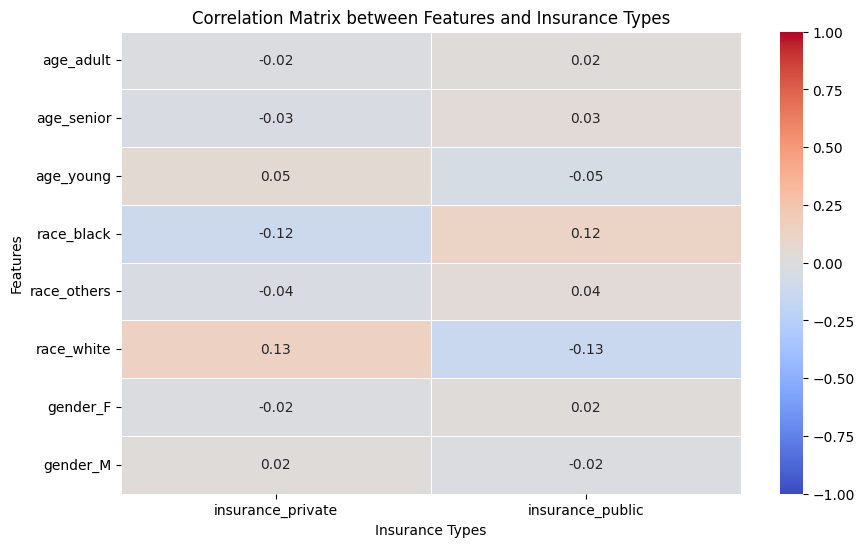

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'confusion_matrix' is your correlation matrix DataFrame
plt.figure(figsize=(10, 6))

# Plot the confusion matrix using seaborn's heatmap with a fixed color range
sns.heatmap(confusion_matrix, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', 
            linewidths=0.5, vmin=-1, vmax=1)

# Add titles and labels for clarity
plt.title("Correlation Matrix between Features and Insurance Types")
plt.xlabel("Insurance Types")
plt.ylabel("Features")

# Show the plot
# plt.show()
plt.savefig("insurance_correlation_matrix.png", dpi=300)


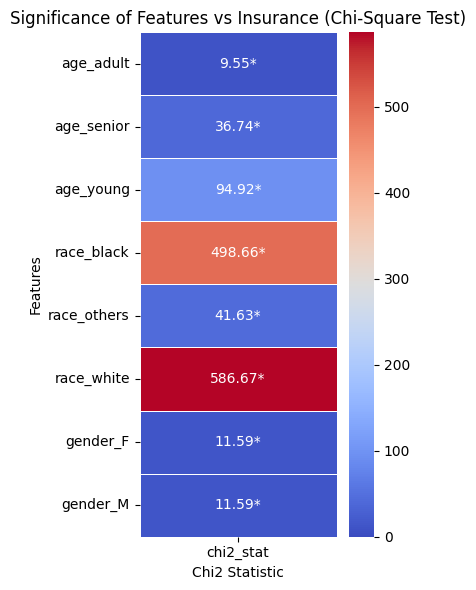

In [5]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# One-Hot Encoding
df_encoded = pd.get_dummies(df_filtered, columns=["age_mapped", "race_mapped", "gender", "insurance_mapped"])
df_encoded.columns = [col.replace('age_mapped_', 'age_') for col in df_encoded.columns]
df_encoded.columns = [col.replace('race_mapped_', 'race_') for col in df_encoded.columns]
df_encoded.columns = [col.replace('insurance_mapped_', 'insurance_') for col in df_encoded.columns]

# Create binary insurance column
df_encoded['insurance'] = df_encoded['insurance_private']
df_encoded.drop(columns=['insurance_private', 'insurance_public'], inplace=True)

# Features to test
categorical_features = [
    'age_adult', 'age_senior', 'age_young', 
    'race_black', 'race_others', 'race_white', 
    'gender_F', 'gender_M'
]

# Run Chi-Square test
chi_square_results = {}
annot_dict = {}

for feature in categorical_features:
    contingency_table = pd.crosstab(df_encoded[feature], df_encoded['insurance'])
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    chi_square_results[feature] = {'chi2_stat': chi2_stat, 'p_value': p_value}
    
    # Format: number with 2 decimals + star if significant
    star = '*' if p_value < 0.05 else ''
    annot_dict[feature] = f"{chi2_stat:.2f}{star}"

# Create DataFrames
chi2_df = pd.DataFrame.from_dict(chi_square_results, orient='index')[['chi2_stat']]
annotation_df = pd.DataFrame.from_dict(annot_dict, orient='index', columns=['annot'])

# Plot
plt.figure(figsize=(4, 6))
sns.heatmap(
    chi2_df, 
    annot=annotation_df, 
    cmap='coolwarm', 
    cbar=True,
    fmt='', 
    linewidths=0.5, 
    vmin=0, 
    vmax=chi2_df['chi2_stat'].max()
)

plt.title("Significance of Features vs Insurance (Chi-Square Test)")
plt.ylabel("Features")
plt.xlabel("Chi2 Statistic")
plt.tight_layout()
plt.savefig("insurance_correlation_matrix_stars.png", dpi=300)
plt.show()


/tmp/ipykernel_3314125/1730386207.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  public = counts.get(0, 0)
/tmp/ipykernel_3314125/1730386207.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  private = counts.get(1, 0)
/tmp/ipykernel_3314125/1730386207.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  public = counts.get(0, 0)
/tmp/ipykernel_3314125/1730386207.py:21: FutureWarning: Series.__getitem__ treating keys as posi

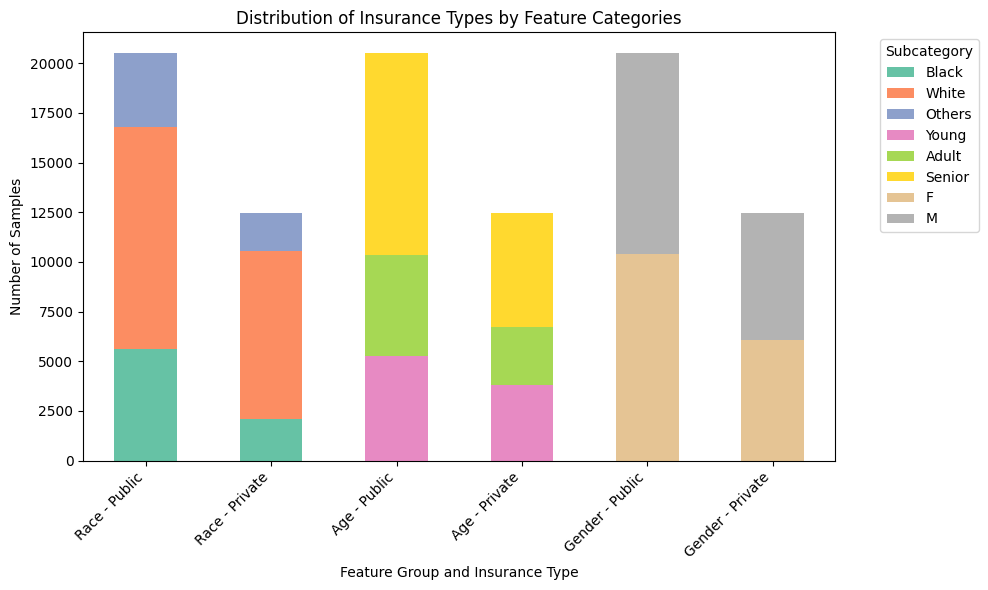

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Define feature groups
feature_groups = {
    'Race': ['race_black', 'race_white', 'race_others'],
    'Age': ['age_young', 'age_adult', 'age_senior'],
    'Gender': ['gender_F', 'gender_M']
}

# Initialize final DataFrame
final_df = pd.DataFrame()

# Collect counts per group
for group_name, features in feature_groups.items():
    for feature in features:
        # Extract only rows where the feature == 1
        subset = df_encoded[df_encoded[feature] == 1]
        counts = subset['insurance'].value_counts()
        public = counts.get(0, 0)
        private = counts.get(1, 0)

        label = feature.replace(f"{group_name.lower()}_", "").capitalize()
        final_df.loc[label, f'{group_name} - Public'] = public
        final_df.loc[label, f'{group_name} - Private'] = private

# Reorder columns
columns_order = []
for group in feature_groups:
    columns_order.extend([f'{group} - Public', f'{group} - Private'])

final_df = final_df[columns_order]

# Plot stacked bar chart
final_df.fillna(0, inplace=True)  # In case of any missing
final_df = final_df.astype(int)

ax = final_df.T.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')

plt.title('Distribution of Insurance Types by Feature Categories')
plt.ylabel('Number of Samples')
plt.xlabel('Feature Group and Insurance Type')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save and show
plt.savefig("all_features_grouped_by_insurance.png", dpi=300)
plt.show()


/tmp/ipykernel_3314125/3541367937.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_public = df_encoded['insurance'].value_counts().get(0, 0)
/tmp/ipykernel_3314125/3541367937.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_private = df_encoded['insurance'].value_counts().get(1, 0)


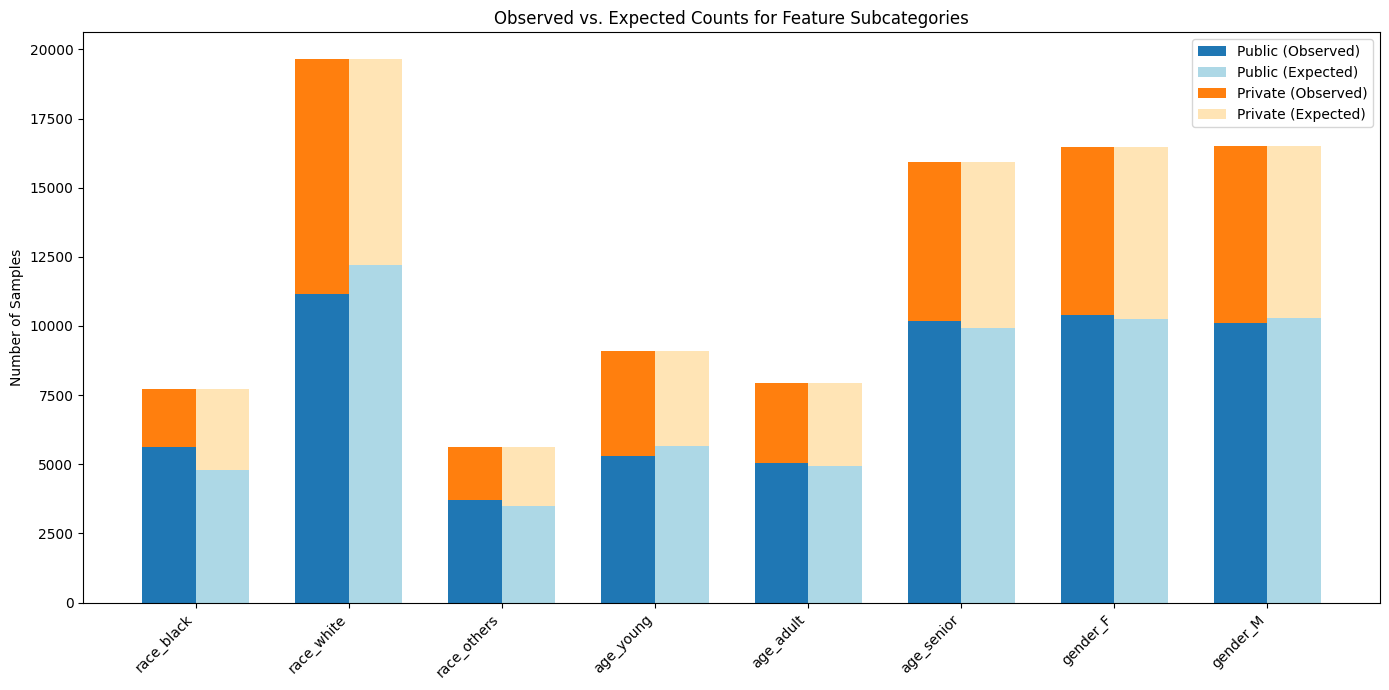

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Combine all subcategories from feature groups
subcategories = [feat for group in feature_groups.values() for feat in group]

# Count totals
total_public = df_encoded['insurance'].value_counts().get(0, 0)
total_private = df_encoded['insurance'].value_counts().get(1, 0)
total = total_public + total_private

# Store observed and expected values
observed_data = []
expected_data = []
labels = []

for feat in subcategories:
    n_total_feat = df_encoded[feat].sum()  # total people in this group
    # Observed
    observed_pub = df_encoded[(df_encoded[feat] == 1) & (df_encoded['insurance'] == 0)].shape[0]
    observed_priv = df_encoded[(df_encoded[feat] == 1) & (df_encoded['insurance'] == 1)].shape[0]
    # Expected (assuming independence)
    expected_pub = n_total_feat * total_public / total
    expected_priv = n_total_feat * total_private / total
    
    labels.append(feat)
    observed_data.append([observed_pub, observed_priv])
    expected_data.append([expected_pub, expected_priv])

# Convert to DataFrames
observed_df = pd.DataFrame(observed_data, index=labels, columns=["Public (Observed)", "Private (Observed)"])
expected_df = pd.DataFrame(expected_data, index=labels, columns=["Public (Expected)", "Private (Expected)"])

# Combine for plotting
combined_df = pd.concat([observed_df, expected_df], axis=1)

# Plot
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(14, 7))

plt.bar(x - width/2, combined_df["Public (Observed)"], width=width, label='Public (Observed)', color='tab:blue')
plt.bar(x + width/2, combined_df["Public (Expected)"], width=width, label='Public (Expected)', color='lightblue')

plt.bar(x - width/2, combined_df["Private (Observed)"], width=width, bottom=combined_df["Public (Observed)"], color='tab:orange', label='Private (Observed)')
plt.bar(x + width/2, combined_df["Private (Expected)"], width=width, bottom=combined_df["Public (Expected)"], color='moccasin', label='Private (Expected)')

plt.xticks(ticks=x, labels=labels, rotation=45, ha='right')
plt.ylabel("Number of Samples")
plt.title("Observed vs. Expected Counts for Feature Subcategories")
plt.legend(loc='upper right')
plt.tight_layout()

# Save and show
plt.savefig("expected_vs_observed_counts.png", dpi=300)
plt.show()


In [8]:
for feature in categorical_features:
    # Select only rows where the feature is 1 (i.e., label is present)
    subset = df_encoded[df_encoded[feature] == 1]
    counts = subset['insurance'].value_counts()
    public = counts.get(0, 0)
    private = counts.get(1, 0)
    print(f"{feature}: public: {public}, private: {private}")


age_adult: public: 5057, private: 2883
age_senior: public: 10188, private: 5757
age_young: public: 5284, private: 3826
race_black: public: 5639, private: 2085
race_others: public: 3721, private: 1915
race_white: public: 11169, private: 8466
gender_F: public: 10409, private: 6079
gender_M: public: 10120, private: 6387


/tmp/ipykernel_3314125/727357025.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  public = counts.get(0, 0)
/tmp/ipykernel_3314125/727357025.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  private = counts.get(1, 0)


In [9]:
import pandas as pd
import scipy.stats as stats

# Perform One-Hot Encoding for categorical columns (age_mapped, race_mapped, gender, insurance_mapped)
df_encoded = pd.get_dummies(df_filtered, columns=["age_mapped", "race_mapped", "gender", "insurance_mapped"])

# Modify the column names to retain the type (age_young, race_black, gender_F, etc.)
df_encoded.columns = [col.replace('age_mapped_', 'age_') for col in df_encoded.columns]
df_encoded.columns = [col.replace('race_mapped_', 'race_') for col in df_encoded.columns]
df_encoded.columns = [col.replace('insurance_mapped_', 'insurance_') for col in df_encoded.columns]

# List of the columns to consider for categorical features
categorical_features = ['age_adult', 'age_senior', 'age_young', 
                        'race_black', 'race_others', 'race_white', 
                        'gender_F', 'gender_M']

# Columns for insurance types (private and public)
insurance_columns = ['insurance_private', 'insurance_public']

# Create an empty dictionary to store the contingency tables and p-values
chi_square_results = {}

# Calculate the contingency table for each feature with the insurance columns
for feature in categorical_features:
    # Create contingency tables for insurance types
    contingency_table = pd.crosstab(df_encoded[feature], df_encoded['insurance_private'])
    
    # Add Insurance: Public column to the table
    contingency_table['Insurance: Public'] = pd.crosstab(df_encoded[feature], df_encoded['insurance_public']).iloc[:, 0]
    
    # Perform Chi-Square Test of Independence
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    # Store the p-value for each feature
    chi_square_results[feature] = {
        'p_value': p_value,
        'contingency_table': contingency_table
    }

# Convert the p-values into a DataFrame for easy visualization
p_values_df = pd.DataFrame({feature: result['p_value'] for feature, result in chi_square_results.items()}, index=["p_value"]).T

# Print the contingency tables and p-values
print("Contingency Tables (Observed Counts):")
print(pd.concat([result['contingency_table'] for result in chi_square_results.values()], keys=chi_square_results.keys()))

print("\nChi-Square Test P-Values:")
print(p_values_df)


Contingency Tables (Observed Counts):
insurance_private      False   True  Insurance: Public
            age_adult                                 
age_adult   False      15472   9583               9583
            True        5057   2883               2883
age_senior  False      10341   6709               6709
            True       10188   5757               5757
age_young   False      15245   8640               8640
            True        5284   3826               3826
race_black  False      14890  10381              10381
            True        5639   2085               2085
race_others False      16808  10551              10551
            True        3721   1915               1915
race_white  False       9360   4000               4000
            True       11169   8466               8466
gender_F    False      10120   6387               6387
            True       10409   6079               6079
gender_M    False      10409   6079               6079
            True       1012

Cramér's V:
           age_adult  age_senior  age_young  race_black  race_others  \
insurance   0.017014    0.033369   0.053637    0.122936     0.035522   

           race_white  gender_F  gender_M  
insurance    0.133344  0.018742  0.018742  

P-values:
           age_adult    age_senior     age_young     race_black   race_others  \
insurance   0.001998  1.350159e-09  1.977746e-22  1.859153e-110  1.100255e-10   

              race_white  gender_F  gender_M  
insurance  1.328530e-129  0.000663  0.000663  


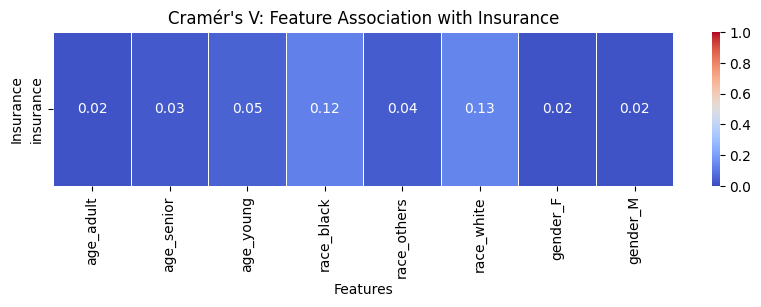

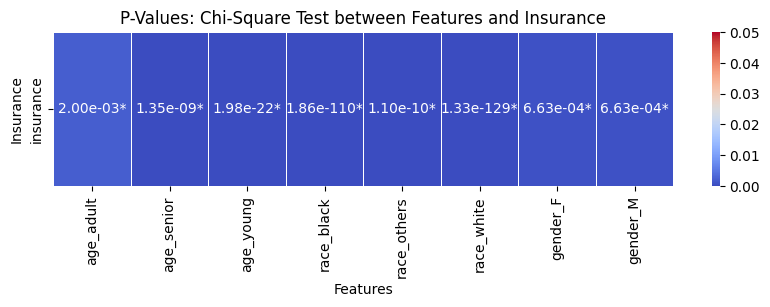

In [10]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Perform One-Hot Encoding
df_encoded = pd.get_dummies(df_filtered, columns=["age_mapped", "race_mapped", "gender", "insurance_mapped"])
df_encoded.columns = [col.replace('age_mapped_', 'age_') for col in df_encoded.columns]
df_encoded.columns = [col.replace('race_mapped_', 'race_') for col in df_encoded.columns]
df_encoded.columns = [col.replace('insurance_mapped_', 'insurance_') for col in df_encoded.columns]

# Choose one insurance column and rename it to 'insurance'
df_encoded['insurance'] = df_encoded['insurance_private']
df_encoded.drop(columns=['insurance_private', 'insurance_public'], inplace=True)

# Categorical features to analyze
categorical_features = ['age_adult', 'age_senior', 'age_young', 
                        'race_black', 'race_others', 'race_white', 
                        'gender_F', 'gender_M']

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2_stat / (n * min_dim))

# Compute Cramér's V and p-values
cramers_v_dict = {}
p_values_dict = {}
p_values_annot = {}

for feature in categorical_features:
    contingency = pd.crosstab(df_encoded[feature], df_encoded['insurance'])
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency)
    cv = cramers_v(contingency)
    
    cramers_v_dict[feature] = cv
    p_values_dict[feature] = p_value
    
    # Format p-value with asterisk if significant
    if p_value < 0.05:
        p_values_annot[feature] = f"{p_value:.2e}*"
    else:
        p_values_annot[feature] = f"{p_value:.2e}"

# Convert to DataFrames
cramers_v_df = pd.DataFrame(cramers_v_dict, index=['insurance'])
p_values_df = pd.DataFrame(p_values_dict, index=['insurance'])
p_values_annot_df = pd.DataFrame(p_values_annot, index=['insurance'])

# Print results
print("Cramér's V:")
print(cramers_v_df)

print("\nP-values:")
print(p_values_df)

# Plot Cramér's V heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(cramers_v_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f',
            linewidths=0.5, vmin=0, vmax=1)

plt.title("Cramér's V: Feature Association with Insurance")
plt.xlabel("Features")
plt.ylabel("Insurance")
plt.savefig("cramers_v_insurance_single.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot p-values heatmap with stars
plt.figure(figsize=(10, 2))
sns.heatmap(p_values_df, annot=p_values_annot_df, cmap='coolwarm', cbar=True, fmt='',
            linewidths=0.5, vmin=0, vmax=0.05)

plt.title("P-Values: Chi-Square Test between Features and Insurance")
plt.xlabel("Features")
plt.ylabel("Insurance")
plt.savefig("p_values_insurance_single.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_3314125/2044856739.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cramers_v_annot_df = cramers_v_df.copy().applymap(lambda x: f"{x:.2f}")


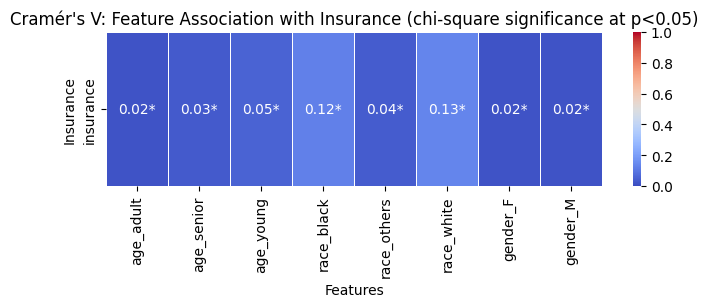

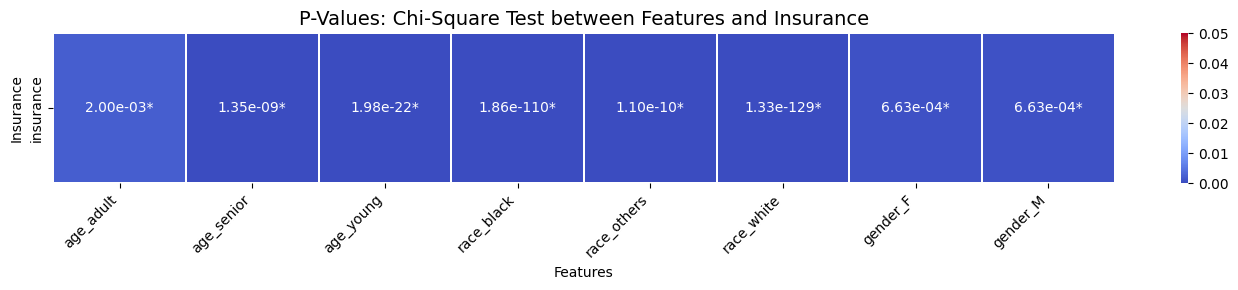

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a copy of the Cramér's V dataframe for annotation
cramers_v_annot_df = cramers_v_df.copy().applymap(lambda x: f"{x:.2f}")

# Add asterisks to significant values (where p < 0.05)
for col in cramers_v_annot_df.columns:
    for idx in cramers_v_annot_df.index:
        if p_values_df.loc[idx, col] < 0.05:
            cramers_v_annot_df.loc[idx, col] = f"{cramers_v_df.loc[idx, col]:.2f}*"

# Plot Cramér's V heatmap with significance markers
plt.figure(figsize=(8, 2))
sns.heatmap(cramers_v_df, 
            annot=cramers_v_annot_df,  # Use our annotated dataframe
            cmap='coolwarm', 
            cbar=True, 
            fmt='',  # Empty since we're providing formatted strings
            linewidths=0.5, 
            vmin=0, 
            vmax=1)

plt.title("Cramér's V: Feature Association with Insurance (chi-square significance at p<0.05)")
plt.xlabel("Features")
plt.ylabel("Insurance")
plt.savefig("cramers_v_matrix_single_col_final.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot p-values heatmap (unchanged from your original)
plt.figure(figsize=(14, 3))
sns.heatmap(
    p_values_df,
    annot=p_values_annot_df,
    cmap='coolwarm',
    cbar=True,
    fmt='',
    linewidths=0.05,
    vmin=0,
    vmax=0.05
)

plt.title("P-Values: Chi-Square Test between Features and Insurance", fontsize=14)
plt.xlabel("Features")
plt.ylabel("Insurance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("p_values_matrix_single_col_wide.png", dpi=300, bbox_inches='tight')
plt.show()

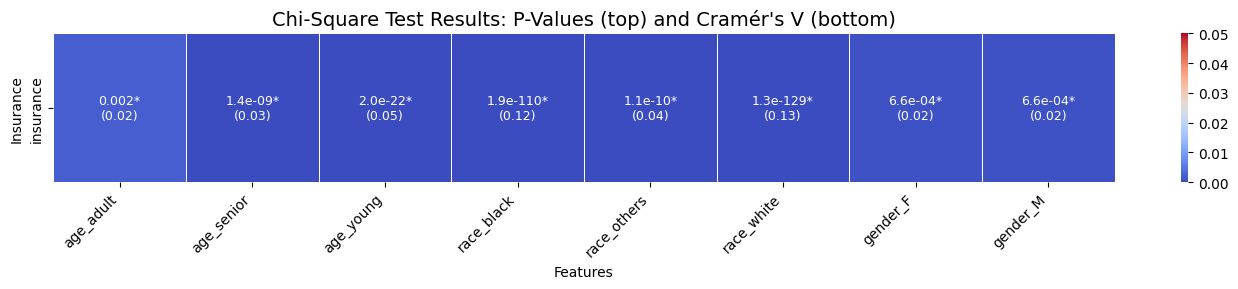

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create combined annotation for p-values and Cramér's V
combined_annot_df = p_values_df.copy().astype(str)

for col in combined_annot_df.columns:
    for idx in combined_annot_df.index:
        p_val = p_values_df.loc[idx, col]
        v_val = cramers_v_df.loc[idx, col]
        
        # Format p-value with scientific notation if very small
        if p_val < 0.001:
            p_str = f"{p_val:.1e}"
        else:
            p_str = f"{p_val:.3f}"
        
        # Create combined annotation
        combined_annot_df.loc[idx, col] = f"{p_str}*\n({v_val:.2f})"

# Plot combined heatmap
plt.figure(figsize=(14, 3))
sns.heatmap(
    p_values_df,
    annot=combined_annot_df,
    cmap='coolwarm',
    cbar=True,
    fmt='',
    linewidths=0.5,
    vmin=0,
    vmax=0.05,
    annot_kws={"size": 9}  # Adjust font size if needed
)

plt.title("Chi-Square Test Results: P-Values (top) and Cramér's V (bottom)", fontsize=14)
plt.xlabel("Features")
plt.ylabel("Insurance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("combined_pvalues_cramersv_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

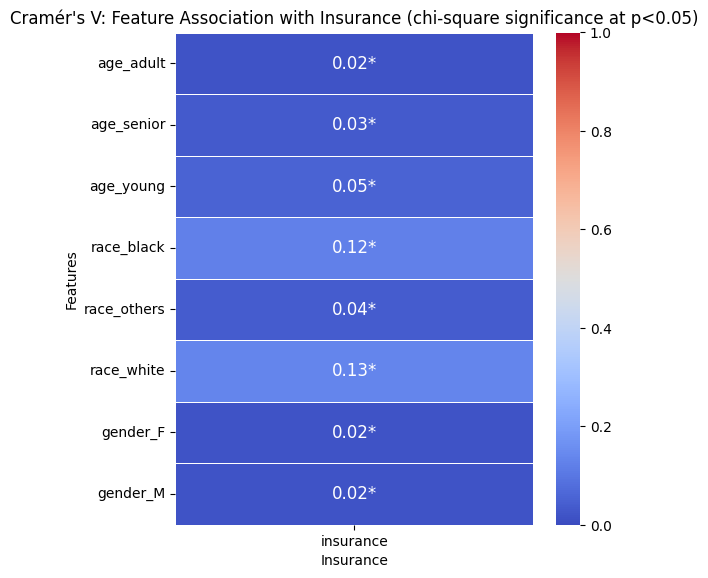

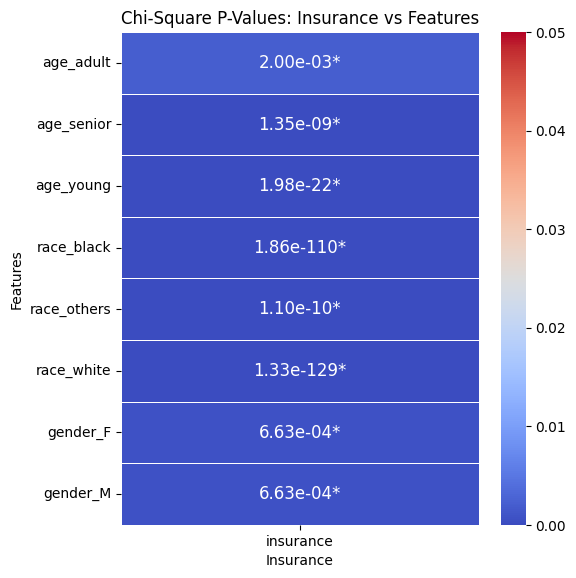

In [15]:
# Build annotation DataFrames: value + star if p < 0.05
cramers_v_annot_df = pd.DataFrame(index=cramers_v_df.index, columns=cramers_v_df.columns)
p_values_annot_df = pd.DataFrame(index=p_values_df.index, columns=p_values_df.columns)

for row in cramers_v_df.index:
    for col in cramers_v_df.columns:
        val = cramers_v_df.loc[row, col]
        pval = p_values_df.loc[row, col]
        star = "*" if pval < 0.05 else ""
        cramers_v_annot_df.loc[row, col] = f"{val:.2f}{star}"       # <== formatted with .2f
        p_values_annot_df.loc[row, col] = f"{pval:.2e}{star}"

# -----------------------------
# 📊 Plot: Cramér's V (transposed, insurance as column)
# -----------------------------
plt.figure(figsize=(6, 6))  # Square-ish figure
ax = sns.heatmap(
    cramers_v_df.T,
    annot=cramers_v_annot_df.T,
    cmap='coolwarm',
    cbar=True,
    fmt='',
    linewidths=0.5,
    vmin=0,
    vmax=1,
    annot_kws={"size": 12, "color": "white"}
)
plt.title("Cramér's V: Feature Association with Insurance (chi-square significance at p<0.05)", fontsize=12)
plt.xlabel("Insurance")
plt.ylabel("Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)  # Insurance
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)  # Features
plt.tight_layout(pad=1.5)
plt.savefig("cramers_v_vertical.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 📊 Plot: P-Values (transposed, insurance as column)
# -----------------------------
plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    p_values_df.T,
    annot=p_values_annot_df.T,
    cmap='coolwarm',
    cbar=True,
    fmt='',
    linewidths=0.5,
    vmin=0,
    vmax=0.05,
    annot_kws={"size": 12, "color": "white"}
)
plt.title("Chi-Square P-Values: Insurance vs Features", fontsize=12)
plt.xlabel("Insurance")
plt.ylabel("Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)  # Insurance
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)  # Features
plt.tight_layout(pad=1.5)
plt.savefig("p_values_vertical.png", dpi=300, bbox_inches='tight')
plt.show()


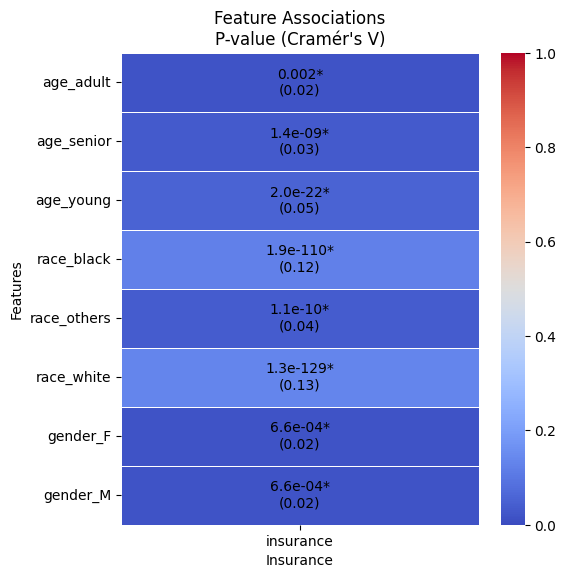

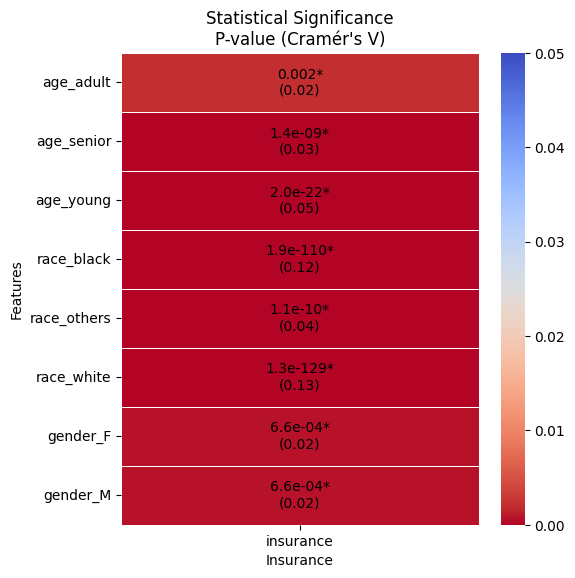

In [24]:
# Build combined annotation DataFrames
cramers_v_annot_df = pd.DataFrame(index=cramers_v_df.index, columns=cramers_v_df.columns)
p_values_annot_df = pd.DataFrame(index=p_values_df.index, columns=p_values_df.columns)
combined_annot_df = pd.DataFrame(index=p_values_df.index, columns=p_values_df.columns)

for row in cramers_v_df.index:
    for col in cramers_v_df.columns:
        val = cramers_v_df.loc[row, col]
        pval = p_values_df.loc[row, col]
        star = "*" if pval < 0.05 else ""
        
        # Format for individual heatmaps
        cramers_v_annot_df.loc[row, col] = f"{val:.2f}{star}"
        p_values_annot_df.loc[row, col] = f"{pval:.2e}{star}"
        
        # Format for combined heatmap: p-value (V)
        if pval < 0.001:
            p_str = f"{pval:.1e}{star}"
        else:
            p_str = f"{pval:.3f}{star}"
        combined_annot_df.loc[row, col] = f"{p_str}\n({val:.2f})"

# -----------------------------
# 📊 Plot 1: Combined Cramér's V with p-value significance
# -----------------------------
plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    cramers_v_df.T,
    annot=combined_annot_df.T,  # Using combined annotation
    cmap='coolwarm',
    cbar=True,
    fmt='',
    linewidths=0.5,
    vmin=0,
    vmax=1,
    annot_kws={"size": 10, "color": "black"}  # Black text for better visibility
)
plt.title("Feature Associations\nP-value (Cramér's V)", fontsize=12)
plt.xlabel("Insurance")
plt.ylabel("Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.tight_layout(pad=1.5)
plt.savefig("combined_cramers_v_vertical.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 📊 Plot 2: Combined P-Values with Cramér's V
# -----------------------------
plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    p_values_df.T,
    annot=combined_annot_df.T,  # Same combined annotation
    cmap='coolwarm_r',  # Reversed colormap (red = significant)
    cbar=True,
    fmt='',
    linewidths=0.5,
    vmin=0,
    vmax=0.05,
    annot_kws={"size": 10, "color": "black"}
)
plt.title("Statistical Significance\nP-value (Cramér's V)", fontsize=12)
plt.xlabel("Insurance")
plt.ylabel("Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.tight_layout(pad=1.5)
plt.savefig("combined_p_values_vertical.png", dpi=300, bbox_inches='tight')
plt.show()

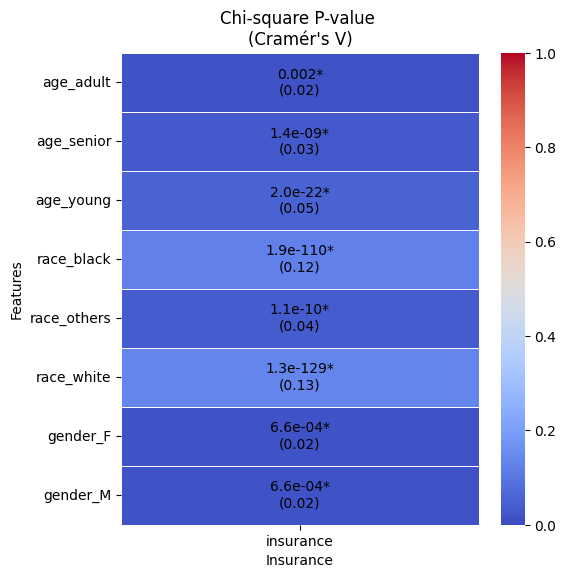

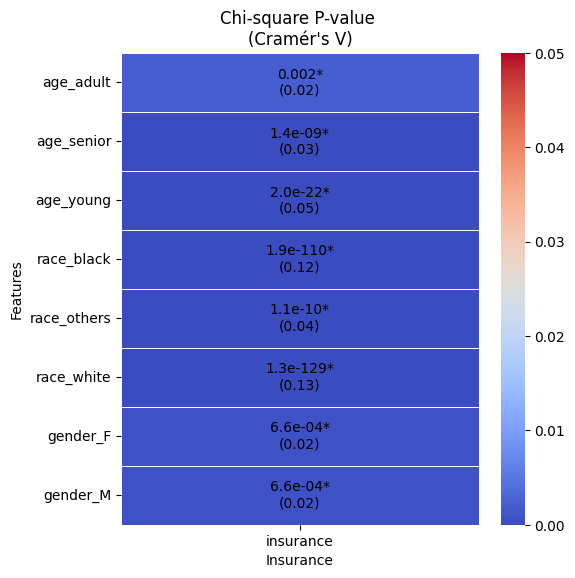

In [25]:
# Build combined annotation DataFrames
combined_annot_df = pd.DataFrame(index=p_values_df.index, columns=p_values_df.columns)

for row in cramers_v_df.index:
    for col in cramers_v_df.columns:
        val = cramers_v_df.loc[row, col]
        pval = p_values_df.loc[row, col]
        star = "*" if pval < 0.05 else ""
        
        # Format for combined annotation: p-value (V)
        if pval < 0.001:
            p_str = f"{pval:.1e}{star}"
        else:
            p_str = f"{pval:.3f}{star}"
        combined_annot_df.loc[row, col] = f"{p_str}\n({val:.2f})"

# -----------------------------
# 📊 Plot 1: Cramér's V Heatmap (0=blue, 1=red)
# -----------------------------
plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    cramers_v_df.T,
    annot=combined_annot_df.T,
    cmap='coolwarm',  # Blue (0) to Red (1)
    cbar=True,
    fmt='',
    linewidths=0.5,
    vmin=0,
    vmax=1,
    annot_kws={"size": 10, "color": "black"}
)
plt.title("Chi-square P-value \n(Cramér's V)", fontsize=12)
plt.xlabel("Insurance")
plt.ylabel("Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.tight_layout(pad=1.5)
plt.savefig("combined_cramers_v_vertical.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 📊 Plot 2: P-Values Heatmap (significant=red, insignificant=blue)
# -----------------------------
plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    p_values_df.T,
    annot=combined_annot_df.T,
    cmap='coolwarm',  # Blue (0) to Red (0.05) - no reverse!
    cbar=True,
    fmt='',
    linewidths=0.5,
    vmin=0,
    vmax=0.05,
    annot_kws={"size": 10, "color": "black"}
)
plt.title("Chi-square P-value \n(Cramér's V)", fontsize=12)
plt.xlabel("Insurance")
plt.ylabel("Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.tight_layout(pad=1.5)
plt.savefig("combined_p_values_vertical.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
p_values_annot_df

,age_adult,age_senior,age_young,race_black,race_others,race_white,gender_F,gender_M
insurance,2.00e-03*,1.35e-09*,1.98e-22*,1.86e-110*,1.10e-10*,1.33e-129*,6.63e-04*,6.63e-04*


### Training models

In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Function to preprocess a DataFrame
def preprocess(df):
    # Encode categorical columns
    label_encoder = LabelEncoder()

    df['gender'] = label_encoder.fit_transform(df['gender'])
    df['insurance_mapped'] = label_encoder.fit_transform(df['insurance_mapped'])
    df['age_mapped'] = label_encoder.fit_transform(df['age_mapped'])
    df['race_mapped'] = label_encoder.fit_transform(df['race_mapped'])

    # Features and labels
    X = df[['gender', 'age_mapped', 'race_mapped']]  # Features
    y = df['insurance_mapped']  # Target
    
    return X, y

# Preprocess the datasets
X_train, y_train = preprocess(df_filtered)
X_val, y_val = preprocess(df_filtered_val)
X_test, y_test = preprocess(df_filtered_test)

# Display a sample of the processed data (Optional)
print(X_train.head(), y_train.head())


   gender  age_mapped  race_mapped
0       0           1            2
1       0           1            2
2       0           1            2
3       0           1            2
4       0           1            2 0    1
1    1
2    1
3    1
4    1
Name: insurance_mapped, dtype: int64


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

# Hyperparameter grid for Random Forest with class balancing
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']  # Include 'balanced' to handle class imbalance
}

# Initialize RandomForestClassifier with class_weight='balanced'
rf_model = RandomForestClassifier(random_state=42, verbose=0)

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=0)
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_rf_model = grid_search_rf.best_estimator_

# Predict and evaluate
y_val_pred_rf = best_rf_model.predict(X_val)
y_test_pred_rf = best_rf_model.predict(X_test)

# Evaluate metrics
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

evaluate_model(y_val, y_val_pred_rf, "Random Forest")
evaluate_model(y_test, y_test_pred_rf, "Random Forest")

# Extract feature importances from the model
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame for feature importances
features = X_train.columns  # Assuming your feature set is a DataFrame with column names
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
print("\nFeature Importances:")
print(feature_importance_df)



Random Forest Metrics:
Accuracy: 0.6310
Precision: 0.6326
Recall: 0.9620
F1-Score: 0.7632
AUC: 0.5286

Random Forest Metrics:
Accuracy: 0.6538
Precision: 0.6615
Recall: 0.9577
F1-Score: 0.7825
AUC: 0.5231

Feature Importances:
       Feature  Importance
2  race_mapped    0.816457
1   age_mapped    0.163833
0       gender    0.019711


In [16]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Check for NaN values in the training data
print(X_train.isnull().sum())
print(y_train.isnull().sum())

# If any NaN values are present, fill them
X_train = X_train.fillna(X_train.mean())  # Replace NaN with column mean
y_train = y_train.fillna(y_train.mode()[0])  # Replace NaN in target with the mode

# Calculate scale_pos_weight based on class imbalance
positive_class_weight = sum(y_train == 1)
negative_class_weight = sum(y_train == 0)
scale_pos_weight = negative_class_weight / positive_class_weight

# Hyperparameter grid for XGBoost with class weights handling
param_grid_xgb = {
    'n_estimators': [100, 200],  # Smaller grid for debugging
    'max_depth': [3, 5],          # Limit depth for debugging
    'learning_rate': [0.01, 0.1],  # Test a few learning rates
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight],  # Adjust for imbalanced classes
}

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', verbosity=0)

# Perform Grid Search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=0, scoring='roc_auc', error_score='raise')
grid_search_xgb.fit(X_train, y_train)

# Get the best hyperparameters
best_xgb_model = grid_search_xgb.best_estimator_

# Predict and evaluate
y_val_pred_xgb = best_xgb_model.predict(X_val)
y_test_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate metrics
evaluate_model(y_val, y_val_pred_xgb, "XGBoost")
evaluate_model(y_test, y_test_pred_xgb, "XGBoost")


gender         0
age_mapped     0
race_mapped    0
dtype: int64
0

XGBoost Metrics:
Accuracy: 0.4962
Precision: 0.6639
Recall: 0.3749
F1-Score: 0.4792
AUC: 0.5338

XGBoost Metrics:
Accuracy: 0.5372
Precision: 0.7606
Recall: 0.4209
F1-Score: 0.5419
AUC: 0.5872


In [17]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Hyperparameter grid for CatBoost with adjusted auto_class_weights
param_grid_catboost = {
    'iterations': [500, 1000, 1500],  # Increased iterations
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Expanded learning rates
    'depth': [6, 8, 10, 12],  # Larger depth values
    'l2_leaf_reg': [3, 5, 10, 15],  # Regularization parameters
    'auto_class_weights': ['Balanced'],  # Set to 'Balanced' for automatic class balancing
    # 'class_weights': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}],  # Manually assign higher weight to the minority class
    'border_count': [64, 128, 256],  # Control the complexity of the model
    'bagging_temperature': [0.1, 0.5, 1.0],  # Controls the randomness of the model (helps with overfitting)
}

# Initialize CatBoost model
catboost_model = CatBoostClassifier(random_state=42, verbose=0, eval_metric='AUC')

# Perform Grid Search with cross-validation and Stratified K-Folds to handle class imbalance
grid_search_catboost = GridSearchCV(estimator=catboost_model, param_grid=param_grid_catboost, cv=5, 
                                    n_jobs=-1, verbose=0, scoring='roc_auc')
grid_search_catboost.fit(X_train, y_train)

# Get the best hyperparameters
best_catboost_model = grid_search_catboost.best_estimator_

# Predict and evaluate
y_val_pred_catboost = best_catboost_model.predict(X_val)
y_test_pred_catboost = best_catboost_model.predict(X_test)

# Evaluate metrics
evaluate_model(y_val, y_val_pred_catboost, "CatBoost")
evaluate_model(y_test, y_test_pred_catboost, "CatBoost")


/local/home/arashasg/Apps/miniconda3/envs/stereoset/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Hyperparameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN model
knn_model = KNeighborsClassifier()

# Perform Grid Search with cross-validation
grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid_knn, cv=5, n_jobs=-1, verbose=0)
grid_search_knn.fit(X_train, y_train)

# Get the best hyperparameters
best_knn_model = grid_search_knn.best_estimator_

# Predict and evaluate
y_val_pred_knn = best_knn_model.predict(X_val)
y_test_pred_knn = best_knn_model.predict(X_test)

# Evaluate metrics
evaluate_model(y_val, y_val_pred_knn, "KNN")
evaluate_model(y_test, y_test_pred_knn, "KNN")



KNN Metrics:
Accuracy: 0.6062
Precision: 0.6478
Recall: 0.7954
F1-Score: 0.7141
AUC: 0.5476

KNN Metrics:
Accuracy: 0.6185
Precision: 0.6785
Recall: 0.7856
F1-Score: 0.7281
AUC: 0.5466


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Hyperparameter grid for Decision Tree with class balancing
param_grid_dt = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']  # Include 'balanced' to handle class imbalance
}

# Initialize DecisionTree model with class_weight as balanced
dt_model = DecisionTreeClassifier(random_state=42)

# Perform Grid Search with cross-validation
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, n_jobs=-1, verbose=0)
grid_search_dt.fit(X_train, y_train)

# Get the best hyperparameters
best_dt_model = grid_search_dt.best_estimator_

# Predict and evaluate
y_val_pred_dt = best_dt_model.predict(X_val)
y_test_pred_dt = best_dt_model.predict(X_test)

# Evaluate metrics
evaluate_model(y_val, y_val_pred_dt, "Decision Tree")
evaluate_model(y_test, y_test_pred_dt, "Decision Tree")



Decision Tree Metrics:
Accuracy: 0.6310
Precision: 0.6326
Recall: 0.9620
F1-Score: 0.7632
AUC: 0.5286

Decision Tree Metrics:
Accuracy: 0.6538
Precision: 0.6615
Recall: 0.9577
F1-Score: 0.7825
AUC: 0.5231


In [ ]:
# Compare all model results after tuning
print("\n--- Model Comparison ---")
print(f"Random Forest Validation Accuracy: {val_accuracy_rf:.4f}, Test Accuracy: {test_accuracy_rf:.4f}")
print(f"XGBoost Validation Accuracy: {val_accuracy_xgb:.4f}, Test Accuracy: {test_accuracy_xgb:.4f}")
print(f"CatBoost Validation Accuracy: {val_accuracy_catboost:.4f}, Test Accuracy: {test_accuracy_catboost:.4f}")
print(f"KNN Validation Accuracy: {val_accuracy_knn:.4f}, Test Accuracy: {test_accuracy_knn:.4f}")
print(f"Decision Tree Validation Accuracy: {val_accuracy_dt:.4f}, Test Accuracy: {test_accuracy_dt:.4f}")



--- Model Comparison ---
Random Forest Validation Accuracy: 0.6310, Test Accuracy: 0.6538
XGBoost Validation Accuracy: 0.6182, Test Accuracy: 0.6504
CatBoost Validation Accuracy: 0.6310, Test Accuracy: 0.6538
KNN Validation Accuracy: 0.6062, Test Accuracy: 0.6185
Decision Tree Validation Accuracy: 0.6310, Test Accuracy: 0.6538
